In [19]:
import pandas as pd
import numpy as np
import pickle
import shutil
import multiprocessing as mp
import cv2
from tqdm import tqdm
import os
import time
import zipfile
from pydicom import dcmread
from skimage import exposure
from PIL import Image as pil_image
import re
from skimage.transform import resize


In [20]:
def get_seriesId_idx(df):
    """
    Based on the content of the columns, defines which one is the 
    'SeriesId'
    
    Returns the index of the columns containing the SeriesId
    """
    
    #finds colums where non unique values are found
    unique_cols=list()
    for idx, col in enumerate(df.columns):
        if len(df[col].unique()) > 1:
            unique_cols.append(idx)
            
    row= df.iloc[1,unique_cols] #pick the first row
    for row_idx, x in enumerate(row) :
        if not re.search('[a-zA-Z]|\-', x):
            row_idx = row_idx
            break
            
    return unique_cols[row_idx]

def get_filename_idx(df):
    """
    Based on the content of the columns, defines which one is the 
    'filename'
    
    Returns the index of the columns containing the Filename
    """
    
    #finds colums where non unique values are found
    unique_cols=list()
    for idx, col in enumerate(df.columns):
        if len(df[col].unique()) > 1:
            unique_cols.append(idx)
            
    row= df.iloc[1,unique_cols] #pick the first row
    for row_idx, x in enumerate(row) :
        if x.endswith('.dcm'):
            row_idx = row_idx
            break #stop the function
            
    return unique_cols[row_idx]

def get_series_description(df, start_string):
    """
    Decodes the description of the serie of imaging 
    """
    
    #finds colums where non unique values are found
    unique_cols=list()
    for idx, col in enumerate(df.columns):
        if len(df[col].unique()) > 1:
            unique_cols.append(idx)
            
    row = df.iloc[1,unique_cols] #pick the first row
    row_desc = False

    for row_idx, x in enumerate(row) :
        if x.startswith(start_string):
            row_desc = row_idx
    
    if row_desc == False:
        raise NameError('Descrition not found')
    else:
        pass
    
    return unique_cols[row_desc]

In [21]:
#Custom exception
class UnusualFolderErr(Exception):
    """
    Custom exception.
    Exception will be raised if the folder has unusual characterisitcs.
    """
    pass

In [22]:
class StackDicom():
    """
    Treats a sequence of dicom images (.dcm) to format it as a stacked .jpg
    """
    
    def __init__(self, ukb_field,series, size, sequence, input_dir,
                 output_dir, zip_dir, instance):
        """
        Create the instance
        """
        self.field = ukb_field # filed sed by UK BioBank
        self.size = size #the h*w size of all the images
        self.sequence = sequence # length of a sequence of images to be stacked
        self.series = series #list of string of series of interest
        self.input_dir = input_dir #directory where the folder is unziped
        self.output_dir = output_dir #where the stack of images will be reached by the NN
        self.zip_dir = zip_dir #where the zip files are downloaded    
        self.instance = instance
                    
        if len(os.sched_getaffinity(0)) > 1:
            cpus = '  Number of processors: {} - Multithreading  '.format(len(os.sched_getaffinity(0)))
            print('-'*len(cpus))
            print(cpus)
            print('-'*len(cpus),'\n')       
    
        self.contrast = False
        
    def _get_shape_(self, file):
        """
        Get the shape of a file
        """
        return np.array(np.load(self.output_dir + file).shape)
        
    def get_shapes(self):
        """
        Check if all the files in the output_dir folder have the same shape
        """
        files = os.listdir(self.output_dir)
        files_npy = [f for f in files if f.endswith('.npy')]
        nb_files = len(files_npy)
        print('{} .npy files.'.format(nb_files))
        
        if len(files) != len(files_npy):
            print('Warning : non .npy files in directory')
        
        pool_ = mp.Pool()
        shapes = pool_.map(self._get_shape_,files_npy)
        pool_.close()
        
        #shapes = np.zeros((nb_files, 4))
            
        return shapes 
    
    def extract_series_img_filename(self, dst_folder):
        """
        Extract specific images form the zip file
        """
        try: #manifest.CVS
            manifest='/manifest.cvs'
            df = pd.read_csv(dst_folder+manifest, index_col=False)
        except FileNotFoundError: #manifest.CSV
            manifest='/manifest.csv'
            df = pd.read_csv(dst_folder+manifest, index_col=False)

        #get the labels of the columns of interest
        img_type = df.columns[get_series_description(df, 'CINE')]
        filename_lab = df.columns[get_filename_idx(df)]        

        #images with series description
        mapped_img_filename =[]
        for ser in self.series:
            mapped_img_filename =  mapped_img_filename + df[df[img_type] == ser][filename_lab].tolist()


        return mapped_img_filename
        
    def unzip_sample(self, zip_):
        """
        Extract the .csv file.
        """
        #moving zip file
        os.rename(self.zip_dir + zip_, dst = self.input_dir + zip_)
        dst_folder = self.input_dir + zip_.replace('.zip', '/')
        
        #if file already exists, replace
        try:
            os.mkdir(dst_folder)
        except FileExistsError: 
            shutil.rmtree(dst_folder)
            os.mkdir(dst_folder)

        
        # Create a ZipFile Object and load sample.zip in it
        with zipfile.ZipFile(self.input_dir + zip_ , 'r') as zipObj:
           # Get a list of all archived file names from the zip
            try:
                manifest = [f for f in zipObj.namelist() if f.startswith('manifest')][0]
                zipObj.extract(manifest, dst_folder) #exctract the manifest.csv
                
                #get sepcifitc files
                filename = self.extract_series_img_filename(dst_folder)
                #unzip them
                if len(filename)> 1:
                    with zipfile.ZipFile(self.input_dir + zip_, 'r') as zipObj2:
                        for file in filename:
                            zipObj2.extract(file, dst_folder)
                else:
                    with zipfile.ZipFile(self.input_dir + zip_, 'r') as zipObj2:
                        zipObj2.extract(filename[0], dst_folder)
                
                #remove zip file
                os.remove(self.input_dir + zip_) 

            except (IndexError, NameError, KeyError) as err:
                #print('not')
                print(self.input_dir + zip_ )
                #remove zip file and directory
                os.remove(self.input_dir + zip_) 
                shutil.rmtree(dst_folder)
    
    def unzip_files(self):
        """
        From the downloaded from the Ukb in the main_data folder,
        Extract the files and removes the zip file.
        """
        zip_files = [z for z in os.listdir(self.zip_dir) if z.endswith('_{}_{}_0.zip'.format(self.field, self.instance))]
        print('Unziping {} Files.'.format(len(zip_files)))
        
        start_t = time.time()
        
        #Unsiping files into self.input_dir
        pool_zip = mp.Pool(len(os.sched_getaffinity(0)))
        for _ in tqdm(pool_zip.imap(self.unzip_sample, zip_files), total = len(zip_files)):
            pass
        
        print(' - Duration = {:0.2f} s\n'.format(time.time()-start_t))
    
    def read_csv(self, directory):
        """
        Read the `manifest` file. returns a Pandas DataFrame
        """
        try: #manifest.CVS
            df = pd.read_csv(directory + '/manifest.cvs', index_col=False)
            return df
            
        except FileNotFoundError: #manifest.CSV
            try:
                df = pd.read_csv(directory + '/manifest.csv', index_col=False)
                return df

            except FileNotFoundError as err:
                raise UnusualFolderErr('No dataframe\n') from err
    
    def sort_dcm(self, df):
        """
        Gather dcm images names by serie description
        """
        #get the label correponding to the filename and description columns 
        #(bad ukb encoding rectification)
        try :
            filename_label = df.columns[get_filename_idx(df)]
            description_label = df.columns[get_series_description(df, 'CINE')]
            series_label = df.columns[get_seriesId_idx(df)]
        except (NameError, IndexError) :
            raise UnusualFolderErr('Description in data frame not found\n')
            
        
        if len(df[series_label].unique() == 3) :
            # 3 df for each CMR orientations
            images_ch2 = df[df[description_label] == self.series[0]][filename_label].tolist()
            images_ch3 = df[df[description_label] == self.series[1]][filename_label].tolist()
            images_ch4 = df[df[description_label] == self.series[2]][filename_label].tolist()

            if (len(images_ch3) != self.sequence or (len(images_ch2) != self.sequence) or (len(images_ch4) != self.sequence)):
                raise UnusualFolderErr('Sequences length missmatch : {}, {}, {} images long\n'.format(len(images_ch2),
                                                                                len(images_ch3), 
                                                                                len(images_ch4)))
            else:
                return images_ch2, images_ch3, images_ch4
        else : #two repititions of the scanning process --> 2 * 3 axis groups
            raise UnusualFolderErr('Two repetitions of series\n')
    
    def load_dcm(self, directory, filenames):
        """
        Load a serie of dcm images. Returns a Np.array() of stacked images
        in *InstanceNumber* order (meta-inforamtion embedded in .dcm file).
        """
        try :
            size = dcmread(directory + '/' + filenames[0]).pixel_array.shape #gets the size
            stack = np.zeros((self.sequence,*size)) 

            for image in sorted(filenames):
                img = dcmread(directory + '/' + image)
                #order the images according to their metadata
                stack[img.InstanceNumber-1, ] = img.pixel_array

            return stack
        except (FileNotFoundError, AttributeError, ValueError): #files in the manifes.csv are not present
            raise UnusualFolderErr('File note found')
    
    def load_resize_stack(self, directory, df):
        """
        Adds zero padding centering the image.
        """
        # Returns 3 stack of images corresponding to the differnet CMR axis
        images_stacks_filenames = self.sort_dcm(df)
        #[nb_frames, height, width, 3_axis]
        final_stack = np.zeros(((self.sequence,) + self.size + (3,)))
        
        for i, image_axis in enumerate(images_stacks_filenames):
            #[nb_frames, height, width]
            stack_img = self.load_dcm(directory, image_axis)
            
            if i==2: # last channel needs to be rotated
                stack_img = stack_img.transpose(0,2,1)
            
            img_shape = stack_img.shape[1:]
            
            height_diff = img_shape[0] - self.size[0]  
            half_h = height_diff//2
            rest_h = height_diff%2 
                
            width_diff = img_shape[1] - self.size[1] 
            half_w = width_diff//2 
            rest_w = width_diff%2

            
            if height_diff > 0:
                
                if width_diff > 0 : # cropping both sides
                    final_stack[:,:,:,i] = stack_img[:, half_h : - half_h - rest_h , half_w : - half_w - rest_w]
                else: # width_diff < 0 
                    final_stack[:,:, - half_w : self.size[1] + half_w + rest_w , i] = stack_img[:, half_h : -half_h - rest_h, :]
            
            else: # height_diff < 0 
                if width_diff > 0 : # zero padding on both sides
                    final_stack[:, - half_h : self.size[0] + half_h + rest_h  , :, i] = stack_img[:, :, half_w : -half_w - width_diff%2]
                else: # width_diff < 0 and height_diff < 0 --> fulld padding
                    final_stack[:, -half_h :  self.size[0] +half_h + height_diff%2,  -half_w  :  self.size[1] + half_w + width_diff%2 , i] = stack_img
        
        return final_stack 
    
    def make_sample(self,folder):
        """
        Deals with single sample. From `folder` of .dcm to a 4D stack of .npy
        """ 
        try :
            directory = self.input_dir + folder
            df = self.read_csv(directory)
            stack = self.load_resize_stack(directory, df)
            np.save(self.output_dir + folder.split('_')[0] +'.npy', stack.astype(np.int16))
            shutil.rmtree(directory) #
        # specific exception raised during the previous methods
        except UnusualFolderErr as err: 
            print('   '+ folder + ' - ', err)
            pass
            
    def make_dataset(self):
        """
        Creates a dataset from a folder name after the patientId
        """
        print('Creating Data-set.')
        folders = os.listdir(self.input_dir)
        string_field = '_{}_{}_0'.format(self.field, self.instance)
        folders = [f for f in folders if f.endswith(string_field)]
        #check for already processed folders
        processed = [p.split('.')[0] + string_field for p in os.listdir(self.output_dir)] #remove '.npy'
        folders = set(folders) - set(processed)
        print(' - {} folders '.format(len(folders)))
        start_t = time.time()
        
        pool_ = mp.Pool(len(os.sched_getaffinity(0)))
        for _ in tqdm(pool_.imap(self.make_sample, folders), total = len(folders)):
            pass

        print('Over')

        print(' - Duration = {:0.2f} s\n'.format(time.time()-start_t))

    # ----------- Reshape samples for videos  ----------
    
    def _save_smaller_file(self, file):
        """
        Take the original images and save a modifided version of it : 
        - smaller or expanded size
        - time undersampling, can shifht undersampling
        - number of heart views/chambers considered
        - constrasted or classic
        - normalize by the maximal pixel intensity --> [0,1] pixel values 
        """
        try :
            x = np.load(self.output_dir + file)
            #reduce image height and width
            if self.smaller_shape:
                if len(self.smaller_shape)>3: # if not all channels/views selected
                    x = x[self.shift_undersampling::self.smaller_shape[0],
                          self.smaller_shape[1]:-self.smaller_shape[1],
                          self.smaller_shape[2]:-self.smaller_shape[2],
                          self.smaller_shape[3]]


                else:
                    x = x[self.shift_undersampling::self.smaller_shape[0],
                          self.smaller_shape[1]:-self.smaller_shape[1],
                          self.smaller_shape[2]:-self.smaller_shape[2],
                          :]

            else: #expand the shape of the image. Centers the image and padds with zeros 
                if len(self.expand_shape)>3: #select certain heart view
                    x= x[self.shift_undersampling::self.expand_shape[0],:,:,self.expand_shape[3]]
                    x = np.pad(x,
                               ((0,0), (self.expand_shape[1], self.expand_shape[1]), (self.expand_shape[2], self.expand_shape[2])),
                               mode='constant')

                else:
                    x= x[self.shift_undersampling::self.expand_shape[0],:,:,:]
                    x = np.pad(x,
                               ((0,0), (self.expand_shape[1], self.expand_shape[1]), (self.expand_shape[2], self.expand_shape[2]), (0,0)),
                               mode='constant')

            #saving name
            if self.shift_undersampling: #if shift in undersampling
                output_filename = self.output_dir_small+file[:-4] + \
                                    str(self.shift_undersampling) + '.npy'
            else: #if no shift, keep original name
                output_filename = self.output_dir_small+file #.replace('.npy', '3.npy')

            #if constrast
            if self.contrast :
                x_contrast = np.zeros_like(x)
                for i in range(x.shape[0]):
                    x_contrast[i,] = exposure.equalize_adapthist(x[i,], clip_limit=0.03)

                x_contrast = x_contrast / x_contrast.max(axis = 2).max(axis= (0,1))

                if self.duplicate_chamber:
                    x = np.stack((x,x,x), axis=-1)
                np.save(output_filename, x_contrast)

            else:
                x = x / x.max(axis = 2).max(axis= (0,1))
                #max_tmp = x.max(axis=(1,2))
                #from 1D vector to 3D matrix
                #max_tmp= np.repeat(max_tmp[:, np.newaxis], (224), axis=1)
                #max_tmp= np.repeat(max_tmp[:, np.newaxis], (224), axis=1)
                #x= np.uint8(np.multiply(x, 255/max_tmp))
                if self.duplicate_chamber:
                    x = np.stack((x,x,x), axis=-1)
                np.save(output_filename, x)
        except ValueError:
            print(self.output_dir + file)
            pass
            
    def save_smaller(self, output_shape, nb_chambers, shift_time = 0, contrast= False, 
                     files = None):
        """
        Save as  [50, 150, 150, 1] with 2nd axis
        
        shift_time : [int] Whether to start the time undersampling from the first or
                    the second frame - shift in undersampling.
                    Value corresponds to thte time shift
        """
        self.constrast = contrast
        # New dimensions for the data:
        #time undersampling
        time_undersampling = self.sequence // output_shape[0]
        if shift_time > time_undersampling-1:
            raise ValueError('Undersampling time shift is not possible with undersampling value')
        else:
            self.shift_undersampling = shift_time # undersampling shift
        #shape modification
        height = int((self.size[0]-output_shape[1])/2)
        width = int((self.size[1]-output_shape[2])/2)
        
        #Number of chambers / view axis
        self.duplicate_chamber = False
        description = {3: 1, 4: 2, 2: 0, 'All' : False} #from nbr of chambers to index
        if (height>=0) and (width >=0):
            self.expand_shape = False #do not expand the original image
            #select a certain view/last dimension index
            if isinstance(description[nb_chambers], int):
                #tuples of index to consider
                self.smaller_shape = (time_undersampling,  height, width , 
                                      description[nb_chambers])
                if len(output_shape) > 3:
                    self.duplicate_chamber = True                    
                
            else : # all the last dimension is taken
                self.smaller_shape = (time_undersampling,  height, width )
        
        else: #expand the original shape
            self.smaller_shape = False
            height = int((output_shape[1]- self.size[0])/2)
            width = int((output_shape[1]- self.size[1])/2)

            if isinstance(description[nb_chambers], int):
                self.expand_shape = (time_undersampling,  height, width , 
                                      description[nb_chambers])
                if len(output_shape) > 3:
                    self.duplicate_chamber = True
                
            else :
                self.expand_shape = (time_undersampling,  height, width )
        
        # defines the output dir, create it if does not exist
        if self.constrast:
            output_dir = '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed'  + str(nb_chambers) + 'ch-constrast' #+ str(output_shape[0]) + 'x' \   + str(output_shape[1]) + 'x'      + str(output_shape[2]) + '-'  \
            if self.duplicate_chamber: 
                output_dir = '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed' +  '-Triple'       + str(nb_chambers) + 'ch-constrast'
        else:
            output_dir = '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed'  + str(nb_chambers) + 'ch'
            if  self.duplicate_chamber: 
                output_dir = '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed'+ '-TripleInt'  \
                            + str(nb_chambers) + 'ch'
                
        output_dir = output_dir + '_{}/'.format(self.instance)
        self.output_dir_small = output_dir 
        
        print(output_dir + ' folder created')
        os.makedirs(output_dir, exist_ok = True)
        
        #files to process, original list of files
        if not files :
            files = os.listdir(self.output_dir) 
        
        #Allready processed files
        if self.shift_undersampling: #files tagged with undersampling shift
            processed = [x for x in os.listdir(output_dir) if len(x)==12]
        else:
            processed = os.listdir(output_dir)
        
        #files to process
        if len(processed) > 0 :
            if self.shift_undersampling:
                print('{} files already processed'.format(len(processed)))
                processed = [x.split('.')[0][:-1]+'.npy' for x in processed]
                files = set(files) - set(processed)
            else:
                print('{} files already processed'.format(len(processed)))
                files = set(files) - set(processed)
        # Parallelisation of job
        if len(files)>0:
            pool_ = mp.Pool(len(os.sched_getaffinity(0)))
            for _ in tqdm(pool_.imap(self._save_smaller_file, files), total=len(files)):
                pass
        else:
            print('All files already processed')
    
    # ----------- Save First image for transfer learning training ----------
    
    def _save_single_image_(self, image):
        """
        Save the first image for a single patient in the output_directory. 
        The nb_chambers enables to choose which heart view observed
        """
        try :
            im = np.load(image)
            if self.nb_chambers_tmp is not None:
                im = im[0, :,:, self.nb_chambers_tmp]
            else :
                im =  im[0, :,:,:]

            if self.contrast:              
                im = exposure.equalize_adapthist(im, clip_limit=0.03)

            if self.npy_format == False:
                im = np.uint8(im * (255/np.max(im, (0,1))))
                filename = self.output_dir_tmp + image.split('/')[-1].replace('.npy','_{}.jpg'.format(self.instance))
                cv2.imwrite(filename, im)
            else:
                im = im/np.max(im, (0,1))
                filename = self.output_dir_tmp + image.split('/')[-1]
                np.save(filename,im)
        
        except ValueError:
            print(image)
            pass
        
    def save_images(self, output_directory, nb_chambers, contrast = False,
                    npy_format=False):
        """
        Save the first image of each patient in the output_directory. The nb_chambers
        enables to choose which heart view observed
        """
        self.npy_format=npy_format
        if contrast:
            self.contrast = True
            
        patients = os.listdir(self.output_dir)
        patients = [self.output_dir + p for p in patients] # add the complete path
        
        dic_chambers = {2:0, 3:1, 4:2, 'all': None}
        if dic_chambers[nb_chambers] is not None:
            self.nb_chambers_tmp = dic_chambers[nb_chambers]
        
        self.output_dir_tmp = output_directory
        
        pool_ = mp.Pool(len(os.sched_getaffinity(0)))
        for _ in tqdm(pool_.imap(self._save_single_image_, patients), total=len(patients)):
            pass

In [23]:
instance = '3' # or '2_2' or '3'
params = {'ukb_field' : '20208',
          'size' : (200, 200),
          'series':  ['CINE_segmented_LAX_2Ch',
                        'CINE_segmented_LAX_3Ch', 
                        'CINE_segmented_LAX_4Ch'] ,
          'sequence': 50,
          'input_dir': '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Raw/',
          'output_dir': '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/',
          'zip_dir' : '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/unzip/',
          'instance' : 3}
dataset = StackDicom(**params)

----------------------------------------------
  Number of processors: 128 - Multithreading  
---------------------------------------------- 



In [24]:
dataset.unzip_files()

Unziping 0 Files.


0it [00:00, ?it/s]

 - Duration = 0.46 s



In [15]:
dataset.make_dataset()

Creating Data-set.
 - 0 folders 


0it [00:00, ?it/s]

Over
 - Duration = 0.45 s



In [35]:
nb_chambers = 3
shift_time = 0
output_shape = (50,200,200)
dataset.save_smaller(output_shape, nb_chambers, shift_time=shift_time,
                     contrast= False)

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed3ch_2/ folder created


  0%|          | 0/632 [00:00<?, ?it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3225593.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3644243.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3449339.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2630924.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3045546.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1934628.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1251152.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4257109.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4913856.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2602390.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5872977.npy
/scratch/0

  0%|          | 1/632 [00:00<03:21,  3.13it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2677288.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4824608.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4460824.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5794944.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2056808.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4306329.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4677243.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5129567.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1510976.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5893792.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1227025.npy
/scratch/

  0%|          | 3/632 [00:01<04:30,  2.32it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4160552.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3567673.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3670356.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4281790.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5602496.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2818045.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3068983.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1083455.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3601081.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1209298.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3792625.npy/scratch/078

  3%|▎         | 16/632 [00:01<00:39, 15.55it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2451498.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4720864.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3926429.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1632418.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5673130.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1808192.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4646020.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1257122.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1090352.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4500980.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1767735.npy
/scratch/0

  3%|▎         | 21/632 [00:03<01:33,  6.54it/s]


/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2005976.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4468604.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2450998.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2803831.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1050042.npy


/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4507175.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1361980.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1730266.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1511190.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2607508.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2732568.npy
/scratch/

 70%|██████▉   | 440/632 [00:03<00:00, 213.25it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3251325.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3907081.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3675728.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1446220.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2386138.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3599713.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4834511.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1145258.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2106162.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5669620.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4309641.npy
/scratch/0

 86%|████████▌ | 544/632 [00:04<00:00, 177.98it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4424164.npy


100%|██████████| 632/632 [00:04<00:00, 145.73it/s]


In [23]:
nb_chambers = 4
shift_time = 0
output_shape = (50,200,200)
dataset.save_smaller(output_shape, nb_chambers, shift_time=shift_time, 
                     contrast= False)


/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test4ch_2/ folder created


  0%|          | 0/632 [00:00<?, ?it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4375511.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1745677.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1897074.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2412397.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1688201.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4141174.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2554105.npy


/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4257109.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3979978.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3254385.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2807612.npy/scratch/07

  8%|▊         | 49/632 [00:00<00:01, 488.28it/s]


/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4703902.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3797387.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5477933.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1251152.npy


/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3904938.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4460824.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4854553.npy


/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3225593.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1009874.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4160552.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/5701591.npy/scratch/0

 16%|█▌        | 98/632 [00:01<00:06, 77.87it/s] 

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4736957.npy



100%|██████████| 632/632 [00:01<00:00, 362.81it/s]


In [24]:
nb_chambers = 2
shift_time = 0
output_shape = (50,200,200)
dataset.save_smaller(output_shape, nb_chambers, shift_time=shift_time, contrast= False)

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test2ch_2/ folder created


  0%|          | 0/632 [00:00<?, ?it/s]

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4375511.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1688201.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4306329.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3601081.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4628514.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2412397.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/2554105.npy

/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3428562.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/3979978.npy/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/4257109.npy
/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/1750450.npy/scratch/07880

  4%|▍         | 25/632 [00:01<00:26, 22.81it/s]

100%|██████████| 632/632 [00:01<00:00, 518.35it/s]


(50, 200, 200, 3)


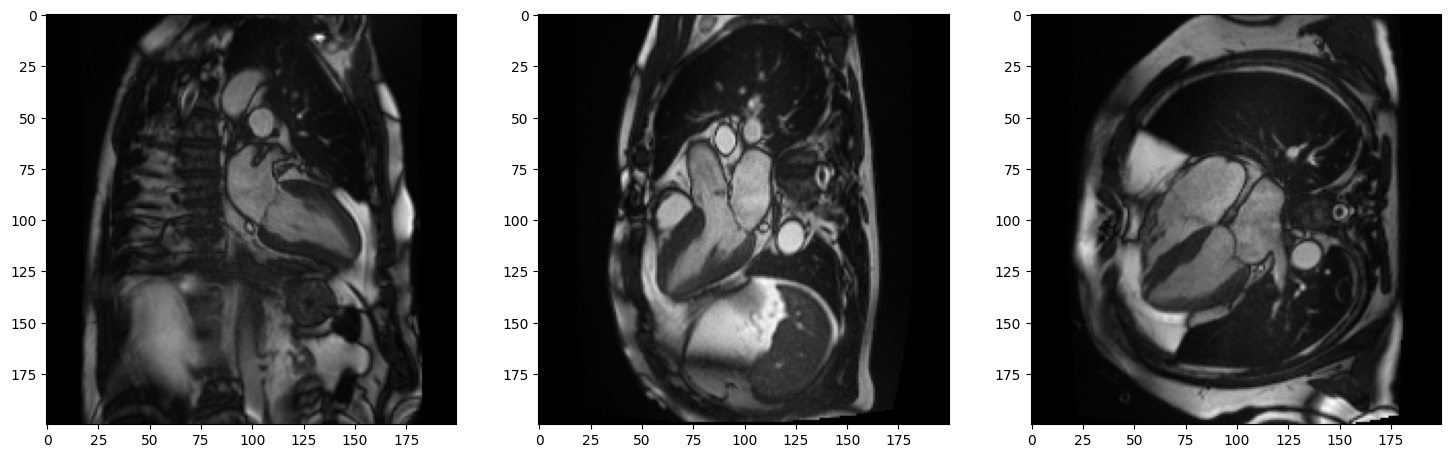

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
output_dir = '/scratch/07880/devansh/CAD/FID20208_heart_long_axis/Processing_test/Processed/'
patient = '2922800.npy'

array = np.load(output_dir + patient)
print(array.shape)
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(array[11,:,:,0], cmap='gray')

plt.subplot(1,3,2)
plt.imshow(array[11,:,:,1], cmap='gray')

plt.subplot(1,3,3)
plt.imshow(array[11,:,:,2], cmap='gray')
plt.show()